<a href="https://colab.research.google.com/github/Y25NHWI/3-2A.I/blob/main/week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

plt.ion()   # interactive mode


In [6]:

!mkdir -p data
!wget -q https://download.pytorch.org/tutorial/hymenoptera_data.zip -O /tmp/hymenoptera_data.zip
!unzip -q /tmp/hymenoptera_data.zip -d data
!ls -R data/hymenoptera_data | head -n 20


data/hymenoptera_data:
train
val

data/hymenoptera_data/train:
ants
bees

data/hymenoptera_data/train/ants:
0013035.jpg
1030023514_aad5c608f9.jpg
1095476100_3906d8afde.jpg
1099452230_d1949d3250.jpg
116570827_e9c126745d.jpg
1225872729_6f0856588f.jpg
1262877379_64fcada201.jpg
1269756697_0bce92cdab.jpg
1286984635_5119e80de1.jpg
132478121_2a430adea2.jpg
1360291657_dc248c5eea.jpg


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


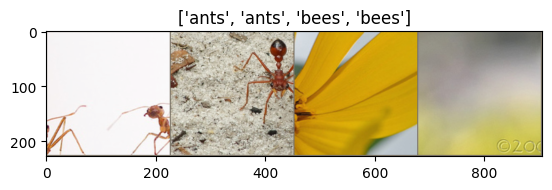

In [8]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.6183 Acc: 0.6639
val Loss: 0.4458 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.4430 Acc: 0.7992
val Loss: 0.3159 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4732 Acc: 0.8033
val Loss: 0.2676 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4642 Acc: 0.7705
val Loss: 0.2326 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4268 Acc: 0.8156
val Loss: 0.2612 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3327 Acc: 0.8402
val Loss: 0.2201 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.3238 Acc: 0.8689
val Loss: 0.2062 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3390 Acc: 0.8279
val Loss: 0.2120 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2944 Acc: 0.8811
val Loss: 0.1957 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3382 Acc: 0.8443
val Loss: 0.2149 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3162 Acc: 0.8443
val Loss: 0.2221 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3281 Acc: 0.8443
val Loss: 0.2311 Acc: 0.8954

Epoch 12/24
----------
t

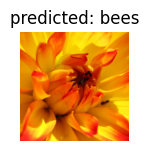

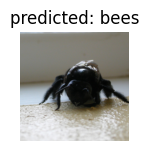

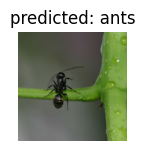

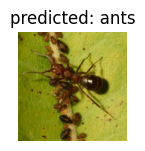

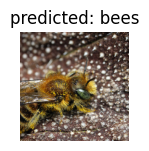

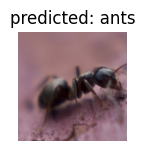

In [11]:
weights = EfficientNet_B0_Weights.DEFAULT
model_ft = efficientnet_b0(weights=weights)

num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)


Epoch 0/24
----------
train Loss: 0.6375 Acc: 0.6311
val Loss: 0.4211 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.4910 Acc: 0.7828
val Loss: 0.3234 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4406 Acc: 0.8115
val Loss: 0.2753 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4032 Acc: 0.8115
val Loss: 0.3076 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4523 Acc: 0.7664
val Loss: 0.2471 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4461 Acc: 0.7787
val Loss: 0.2280 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4743 Acc: 0.7746
val Loss: 0.2440 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.3664 Acc: 0.8648
val Loss: 0.2274 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4063 Acc: 0.8320
val Loss: 0.2254 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.4315 Acc: 0.8074
val Loss: 0.2229 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4188 Acc: 0.7992
val Loss: 0.2485 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.4214 Acc: 0.7951
val Loss: 0.2337 Acc: 0.9281

Ep

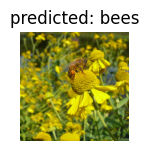

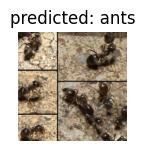

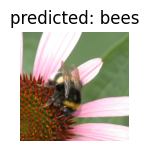

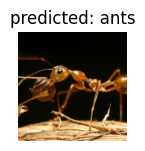

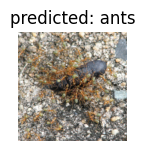

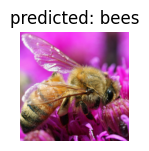

In [14]:
weights = EfficientNet_B0_Weights.DEFAULT
model_conv = efficientnet_b0(weights=weights)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[1].in_features
model_conv.classifier[1] = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier[1].parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv)

plt.ioff()
plt.show()


In [16]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

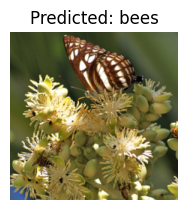

In [17]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()